In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import centrality, link_analysis
import numpy as np
import pandas as pd
import os
import random
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
random.seed(4)

'1.11'

In [8]:
class DMBI_hackathon_ddi_utils():
    NODE_1 = 'node1'
    NODE_2 = 'node2'
    def __init__(self,number_of_drugs = 1434):
        self.number_of_drugs =number_of_drugs

    def write_list_to_file(self, list, path):
        thefile = open(path, 'w')
        for item in list:
            thefile.write("%s\n" % item)
        thefile.close()

    def read_sparse_matrix(self,train_data):
        print('creating matrix')
        x = train_data[self.NODE_1]
        y = train_data[self.NODE_2]
        assert len(x) == len(y)
        data = [1] * len(x)
        m = csr_matrix((data,(x,y)), shape=(self.number_of_drugs, self.number_of_drugs),dtype='f')
        print('m shape:', m.shape, 'm non zeros:', m.nnz)
        assert np.allclose(m.todense(), m.T.todense(), atol=1e-8) #matrix is symmetric
        return m.todense()#the matrix is small, sparse matrix is not necessary.
    
    def write_solution_to_file(self,preds,file_path, num_interactions_train):
        #preds is assumed to be ordered by confidence level
        #adds the header to the soution, combines the node IDs and writes the soךution to file
        #asserts are important. Note them.
        
        print(f'writing predictions to file: {file_path}')
        for u, v in preds:
           assert u < v, 'graph is undirected, predict edges where the first node id is smaller than the second only'
        assert len(preds) == (self.number_of_drugs * self.number_of_drugs - self.number_of_drugs - num_interactions_train) / 2, "number of predictions is equal to number of non existing edges"
        output = [','.join([self.NODE_1 + '_' + self.NODE_2])]+[','.join([str(p[0]) +'_' + str(p[1])]) for p in preds]
        self.write_list_to_file(output,file_path)

    def create_holdout_set(self,m_train,train_percent = 0.9):
        #create holdout set. the set will contains both existing and non-existing edges.
        m_train_holdout = np.matrix(m_train)
        validation_set = set()
        for i in range(self.number_of_drugs):
            for j in range(i+1,self.number_of_drugs):
                if random.random()>train_percent:
                    validation_set.add((i,j))
                    m_train_holdout[i,j] = 0
                    m_train_holdout[j, i] = 0
        return m_train_holdout,validation_set

    def average_precision_at_k(self,k, class_correct):
        #return average precision at k.
        #more examples: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
        #and: https://www.kaggle.com/c/avito-prohibited-content#evaluation
        #class_correct is a list with the binary correct label ordered by confidence level.
        assert k <= len(class_correct) and k > 0        
        score = 0.0
        hits = 0.0
        for i in range(k):
            if class_correct[i]==1:
                hits += 1.0
            score += hits /(i+1.0)
        score /= k
        return score



In [125]:
#simple prediction class
class link_prediction_predictor:
    def __init__(self,number_of_drugs):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(number_of_drugs))

    def fit(self,edge_list):
        self.G.add_edges_from(edge_list)

    def predict(self,prediction_set=None):
        preds = nx.resource_allocation_index(self.G,ebunch=prediction_set)  
        # if ebunch is None then all non-existent edges in the graph will be used.
        preds = [(u1, v1) for (p, u1, v1) in sorted([(prediction, u, v) for (u, v, prediction) in preds],reverse=True)]  
        #predictions are expected as described in write_solution_to_file. The values are suppose to be ordered by confidence.
        return preds
    
    def predict_jaccard(self,prediction_set=None):
        preds = nx.jaccard_coefficient(self.G,ebunch=prediction_set)  
        # if ebunch is None then all non-existent edges in the graph will be used.
        preds = [(u1, v1) for (p, u1, v1) in sorted([(prediction, u, v) for (u, v, prediction) in preds],reverse=True)]  
        #predictions are expected as described in write_solution_to_file. The values are suppose to be ordered by confidence.
        return preds        
    
    def predict_preferential_attachment(self,prediction_set=None):
        preds = nx.preferential_attachment(self.G,ebunch=prediction_set)  
        # if ebunch is None then all non-existent edges in the graph will be used.
        preds = [(u1, v1) for (p, u1, v1) in sorted([(prediction, u, v) for (u, v, prediction) in preds],reverse=True)]  
        #predictions are expected as described in write_solution_to_file. The values are suppose to be ordered by confidence.
        return preds        
        
        

In [10]:
DMBI_hackathon_ddi = DMBI_hackathon_ddi_utils()
train_matrix = DMBI_hackathon_ddi.read_sparse_matrix(pd.read_csv('train.csv'))


creating matrix
m shape: (1434, 1434) m non zeros: 93200


In [13]:
train_matrix[71,407]

1.0

In [122]:
### full graph
m_train_holdout,validation_set = DMBI_hackathon_ddi.create_holdout_set(train_matrix,train_percent=1)
x,y = m_train_holdout.nonzero() #x and y indeices of nonzero cells (existing edges)
edge_list = list(zip(x,y)) 
link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
link_prediction.fit(edge_list)

In [12]:
n = [i for i in range(0,1433) if i not in [71,407]]

In [13]:
G = link_prediction.G
G = G.subgraph(n)

In [126]:
#Evaluate model. 
#Note that holdout is based on random decision. 
m_train_holdout,validation_set = DMBI_hackathon_ddi.create_holdout_set(train_matrix)
x,y = m_train_holdout.nonzero() #x and y indeices of nonzero cells (existing edges)
edge_list = list(zip(x,y)) 
link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
link_prediction.fit(edge_list)

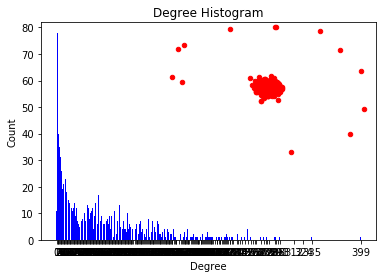

In [41]:
import collections
G = link_prediction.G
#degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degree_sequence = sorted([d for n, d in G.degree().items()], reverse=True)  # degree sequence nx 1.01

# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

In [ ]:
def hist_generator(name,seq):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    count = collections.Counter(seq)
    deg, cnt = zip(*count.items())
    
    plt.figure(figsize=(10,9))
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(name + " Histogram")
    plt.ylabel("Count")
    plt.xlabel(name)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

# node based features

In [146]:
def get_nodes_df(G):
    df_nodes = pd.DataFrame(index=G.nodes())
    df_nodes['clustering'] = pd.Series(nx.clustering(G))
    df_nodes['degree'] = pd.Series(dict(G.degree()))
    df_nodes['degree_centrality'] =  pd.Series(centrality.degree_centrality(G))
    df_nodes['closeness_centrality'] =  pd.Series(centrality.closeness_centrality(G))
    df_nodes['betweenness_centrality'] =  pd.Series(centrality.betweenness_centrality(G))
    df_nodes['pagerank'] = pd.Series(link_analysis.pagerank(G))
    # df_nodes.to_csv('nodes.csv')
    return df_nodes

# Edge based features


In [144]:
def get_edges_df(G):
    pairs = pd.DataFrame(nx.to_edgelist(G))[[0,1]]
    #pairs = nx.to_pandas_edgelist(G)
    pairs.columns = ['node1','node2']
    pairs['is_edge'] = 1
    un_pairs = pd.DataFrame(nx.to_edgelist(nx.Graph(nx.non_edges(G))))[[0,1]]
    #un_pairs = nx.to_pandas_edgelist(nx.Graph(nx.non_edges(G)))
    un_pairs.columns = ['node1','node2']
    un_pairs['is_edge'] = 0
    total_edges = pd.concat([pairs,un_pairs],axis=0)
    total_edges = total_edges.sort_values(by=['node1','node2'])
    common_friends = [len([j for j in nx.common_neighbors(G,row['node1'],row['node2'])]) for i,row in total_edges.iterrows()  ]
    total_edges['common_friends'] = common_friends
    total_edges['jaccard_coefficient'] = pd.DataFrame(nx.jaccard_coefficient(G))[2]
    total_edges['adamic_adar_index'] = pd.DataFrame(nx.adamic_adar_index(G))[2]
    total_edges['resource_allocation_index'] = pd.DataFrame(nx.resource_allocation_index(G))[2]
    total_edges['preferential_attachment'] = pd.DataFrame(nx.preferential_attachment(G))[2]
    sh = nx.all_pairs_shortest_path_length(G)
    total_edges['shortest_path_length'] = [-1 if not (int(row['node1']) in sh.keys() and int(row['node2']) in sh[int(row['node1'])].keys()) else sh[int(row['node1'])][int(row['node2'])] for i,row in total_edges.iterrows()]
    return total_edges

In [147]:
def get_features_df(G):
    df_nodes = get_nodes_df(G)
    total_edges = get_edges_df(G)
    df = total_edges.merge(df_nodes,how='left',right_index = True,left_on='node1')
    df = df.merge(df_nodes,how='left',right_index = True,left_on='node2',suffixes=("_node1","_node2"))
    return df

In [148]:
train_table = get_features_df(G)

MemoryError: 

In [58]:
train_table

Index(['node1', 'node2', 'is_edge', 'common_friends', 'jaccard_coefficient',
       'adamic_adar_index', 'resource_allocation_index',
       'preferential_attachment', 'shortest_path_length', 'clustering_node1',
       'degree_node1', 'degree_centrality_node1', 'closeness_centrality_node1',
       'betweenness_centrality_node1', 'pagerank_node1', 'clustering_node2',
       'degree_node2', 'degree_centrality_node2', 'closeness_centrality_node2',
       'betweenness_centrality_node2', 'pagerank_node2'],
      dtype='object')

In [59]:
train_table[['common_friends','jaccard_coefficient',
       'adamic_adar_index', 'resource_allocation_index',
       'preferential_attachment', 'shortest_path_length']].rank

<bound method NDFrame.rank of         common_friends  jaccard_coefficient  adamic_adar_index  \
0                    0             0.000000           0.000000   
1                    0             0.000000           0.000000   
2                    0             0.000000           0.000000   
3                    0             0.000000           0.000000   
4                    0             0.000000           0.000000   
5                    0             0.000000           0.000000   
6                    0             0.000000           0.000000   
7                    0             0.000000           0.000000   
8                    0             0.000000           0.000000   
9                    0             0.000000           0.000000   
10                   0             0.000000           0.000000   
11                   0             0.000000           0.000000   
12                   1             0.058824           0.261189   
13                   0             0.000000   

In [67]:
train_table['common_friends_rank'] = train_table['common_friends'].rank(method='first',ascending = False)

In [70]:
train_table['jaccard_coefficient_rank'] = train_table['jaccard_coefficient'].rank(method='first',ascending = False)
train_table['adamic_adar_index_rank'] = train_table['adamic_adar_index'].rank(method='first',ascending = False)
train_table['resource_allocation_index_rank'] = train_table['resource_allocation_index'].rank(method='first',ascending = False)
train_table['preferential_attachment_rank'] = train_table['preferential_attachment'].rank(method='first',ascending = False)
train_table['shortest_path_length_rank'] = train_table['shortest_path_length'].rank(method='first',ascending = False)


In [89]:
avg.head()

,0,node1,node2
984409,1026988.25,1399,1413
980822,1025637.50,1350,1399
979266,1025134.75,1335,1404
979219,1025113.75,1335,1357
974166,1023488.75,1294,1399


In [110]:
avg = pd.DataFrame(train_table[['jaccard_coefficient_rank','resource_allocation_index_rank','preferential_attachment_rank'
                   ,'shortest_path_length_rank']].mean(axis=1))
avg['node1'] = train_table['node1']
avg['node2'] = train_table['node2']
avg = avg.sort_values(by=0,ascending=False)
avg['pair'] = [str(int(row['node1']))+","+str(int(row['node2'])) for i,row in avg.iterrows()]
s_v = [ str(x) + "," + str(y) for (x,y) in validation_set]
avg_val = avg[avg['pair'].isin(s_v)]
preds = [(int(row['node1']),int(row['node2'])) for i,row in avg_val.iterrows()]
print(preds)

[(1294, 1399), (1381, 1399), (1243, 1358), (1379, 1399), (1328, 1399), (1127, 1335), (1174, 1335), (1359, 1390), (1354, 1403), (1351, 1365), (1350, 1359), (1350, 1357), (1334, 1363), (1098, 1224), (1386, 1410), (1294, 1300), (1381, 1418), (1289, 1297), (1285, 1410), (1398, 1410), (1074, 1123), (1364, 1381), (1261, 1431), (1261, 1319), (1331, 1432), (1255, 1311), (1255, 1257), (1254, 1430), (1254, 1403), (1254, 1332), (1254, 1331), (1254, 1327), (1120, 1285), (1120, 1256), (1120, 1210), (1120, 1201), (1120, 1176), (1311, 1315), (1322, 1418), (1321, 1359), (1302, 1365), (1241, 1360), (1310, 1337), (1303, 1320), (1332, 1372), (1310, 1390), (1111, 1243), (1263, 1295), (1410, 1429), (1214, 1268), (1213, 1350), (1212, 1269), (1120, 1262), (1211, 1250), (1210, 1323), (1210, 1245), (1325, 1342), (1325, 1326), (1324, 1416), (1364, 1390), (1081, 1120), (1363, 1364), (1206, 1272), (1358, 1386), (1310, 1404), (1290, 1292), (1322, 1404), (1245, 1422), (1281, 1292), (1250, 1276), (1303, 1341), (1189

In [107]:
[ str(x)+"," +str(y) for (x,y) in validation_set]

['160,950',
 '33,440',
 '363,849',
 '531,681',
 '146,761',
 '517,902',
 '164,1394',
 '259,938',
 '132,420',
 '609,621',
 '104,115',
 '544,1264',
 '270,302',
 '1118,1342',
 '475,764',
 '1199,1359',
 '761,951',
 '424,1198',
 '64,1109',
 '373,1237',
 '32,367',
 '69,912',
 '694,1421',
 '87,459',
 '36,1051',
 '207,774',
 '573,1260',
 '1187,1308',
 '262,589',
 '156,192',
 '195,634',
 '253,1092',
 '414,664',
 '329,652',
 '43,1418',
 '3,1379',
 '333,984',
 '47,798',
 '347,1072',
 '14,508',
 '35,719',
 '166,267',
 '39,539',
 '261,1393',
 '1254,1386',
 '136,330',
 '9,732',
 '742,1118',
 '869,984',
 '1330,1370',
 '768,1099',
 '251,401',
 '585,1425',
 '518,975',
 '673,1218',
 '285,1320',
 '571,751',
 '440,1115',
 '1069,1316',
 '165,850',
 '6,1374',
 '77,1158',
 '426,1106',
 '338,390',
 '232,925',
 '356,963',
 '451,701',
 '345,1186',
 '437,1394',
 '109,757',
 '570,1145',
 '102,326',
 '139,456',
 '342,1201',
 '455,1138',
 '37,505',
 '58,744',
 '228,1044',
 '344,1301',
 '175,623',
 '32,727',
 '468,47

In [141]:
#Test set contains new interactions that random selection does not emulate.
# predictor: jaccard coeffients
preds = link_prediction.predict_jaccard(validation_set)
class_correct = [train_matrix[x[0],x[1]] for x in preds]
average_precision = DMBI_hackathon_ddi.average_precision_at_k(k=100,class_correct=class_correct)
print(f'average precision @ 100: {average_precision}')

average precision @ 100: 0.02083717281213365


In [142]:
#Test set contains new interactions that random selection does not emulate.
# predictor: jaccard preferential_attachment
preds = link_prediction.predict_preferential_attachment(validation_set)
class_correct = [train_matrix[x[0],x[1]] for x in preds]
average_precision = DMBI_hackathon_ddi.average_precision_at_k(k=100,class_correct=class_correct)
print(f'average precision @ 100: {average_precision}')

average precision @ 100: 0.7065021571714227


In [143]:
#Test set contains new interactions that random selection does not emulate.
# predictor: resource_allocation
preds = link_prediction.predict(validation_set)
class_correct = [train_matrix[x[0],x[1]] for x in preds]
average_precision = DMBI_hackathon_ddi.average_precision_at_k(k=100,class_correct=class_correct)
print(f'average precision @ 100: {average_precision}')

average precision @ 100: 0.6149102560145554


In [6]:
#Create final submission file
x,y = train_matrix.nonzero()
num_interactions_train = len(x);assert len(x)==len(y)
edge_list = list(zip(x,y))
link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
link_prediction.fit(edge_list)
preds = link_prediction.predict()
DMBI_hackathon_ddi.write_solution_to_file(preds,'sample_predictions.csv',num_interactions_train=num_interactions_train)

writing predictions to file: sample_predictions.csv
